<a href="https://colab.research.google.com/github/CLiz17/densenet-deepfake/blob/main/custom_densenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


No. of images loaded: 854
No. of labels loaded: 854
Images shape: (854, 150, 150, 3)
Labels shape: (854,)
Training set size: 1366
Validation set size: 342
Epoch 1/10
22/22 [==============================] - 98s 4s/step - loss: 0.1023 - accuracy: 0.9546 - val_loss: 113.8479 - val_accuracy: 0.3158
Epoch 2/10
22/22 [==============================] - 85s 4s/step - loss: 0.0193 - accuracy: 0.9912 - val_loss: 22.1429 - val_accuracy: 0.3158
Epoch 3/10
22/22 [==============================] - 92s 4s/step - loss: 0.0097 - accuracy: 0.9985 - val_loss: 6.5368 - val_accuracy: 0.5380
Epoch 4/10
22/22 [==============================] - 83s 4s/step - loss: 0.0126 - accuracy: 0.9971 - val_loss: 24.1956 - val_accuracy: 0.3158
Epoch 5/10
22/22 [==============================] - 90s 4s/step - loss: 8.9911e-04 - accuracy: 1.0000 - val_loss: 25.1409 - val_accuracy: 0.3158
Epoch 6/10
22/22 [==============================] - 87s 4s/step - loss: 7.7615e-04 - accuracy: 1.0000 - val_loss: 27.7101 - val_accuracy

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


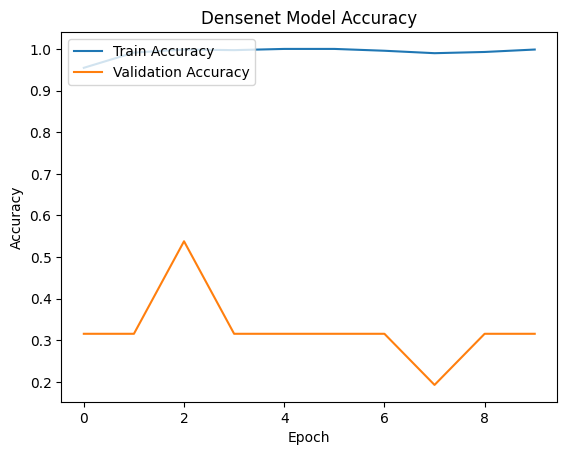

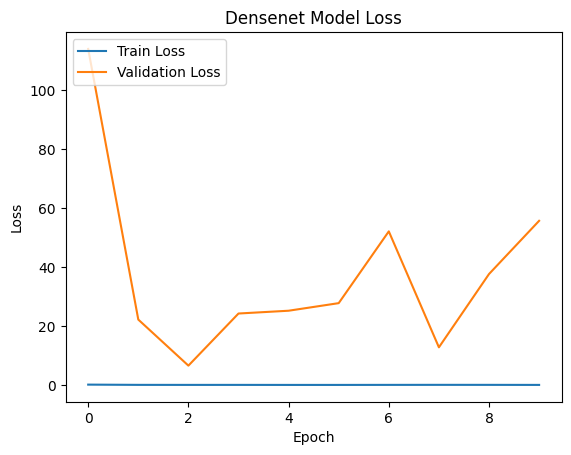

6/6 [==============================] - 15s 2s/step


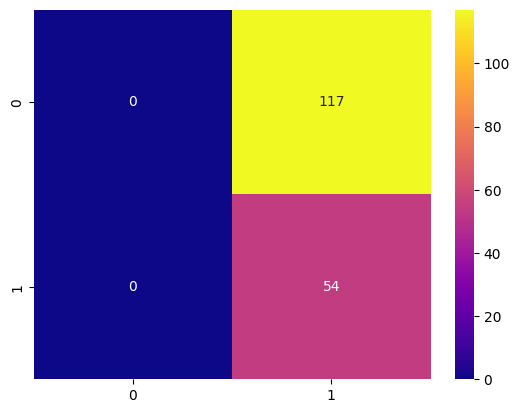

In [6]:
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dropout, Flatten, BatchNormalization, Dense, Activation
from tensorflow.keras.applications.densenet import DenseNet121

def load_images_and_labels(fpath):
    images = []
    labels = []
    categories = os.listdir(fpath)

    for index, category in enumerate(categories):
        category_path = os.path.join(fpath, category)
        for image_name in os.listdir(category_path):
            image_path = os.path.join(category_path, image_name)
            img = cv2.imread(image_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_array = Image.fromarray(img, 'RGB')
            resized_img = img_array.resize((150, 150))
            images.append(np.array(resized_img))
            labels.append(index)

    return np.array(images), np.array(labels)

# Define paths and load data
fpath = "/content/drive/MyDrive/densenet-deepfake/dataset"
images, labels = load_images_and_labels(fpath)

print("No. of images loaded:", len(images))
print("No. of labels loaded:", len(labels))
print("Images shape:", images.shape)
print("Labels shape:", labels.shape)
# print("Data types - Images:", type(images), ", Labels:", type(labels))

# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

print("Training set size:", len(x_train)+len(y_train))
print("Validation set size:", len(x_test)+len(y_test))

# Data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow(
    x_train,
    y_train,
    batch_size=32
)

validation_generator = train_datagen.flow(
    x_test,
    y_test,
    batch_size=32
)

# Define the model architecture
dense_model = DenseNet121(input_shape=(150,150,3), include_top=False, weights="imagenet")
for layer in dense_model.layers:
    layer.trainable=False

model = Sequential([
    dense_model,
    Dropout(0.5),
    Flatten(),
    BatchNormalization(),
    Dense(2048, kernel_initializer='he_uniform'),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    Dense(1024, kernel_initializer='he_uniform'),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=opt)

# Train the model
hist = model.fit(
    train_generator,
    epochs=10,
    validation_data=(x_test, y_test)
)

# Save the model weights
model.save('model.h5')

# Plot accuracy and loss curves
plt.plot(hist.history['accuracy'], label='Train Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.title('Densenet Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

plt.plot(hist.history['loss'], label='Train Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Densenet Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Generate confusion matrix
y_pred = model.predict(x_test) > 0.5
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap="plasma", fmt="d", annot=True)

# Load the trained model
model = load_model("/content/model.h5")

# Prediction function
def predict(file_path):
    img = load_img(file_path, target_size=(150, 150))
    img = img_to_array(img) / 255
    img = np.expand_dims(img, axis=0)
    prediction = model.predict(img)
    if prediction < 0.5:
        return "The image is a deepfake"
    else:
        return "The image is of a real person"